In [1]:
import numpy as np
from scipy.stats import dirichlet
import tqdm
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import gamma


def generate_xt(n_pars, hm):
    xt = []
    for _ in range(hm):
        temp = np.linspace(10,1,n_pars) * np.random.uniform(0,1,n_pars)
        xt.append(temp/np.sum(temp))
    return np.array(xt)

def loglikelihood(xt, omega):
    return np.sum( np.log( np.array( [ np.sum(xt[i]*omega) for i in range(len(xt)) ] ) ) )

def log_posterior(xt, omega, alpha):
    return loglikelihood(xt, omega) + dirichlet.logpdf(omega, alpha = alpha)

def sampling(n, xt, alpha, alpha_prop):
    accepted = []
    c = 0
    log_rnd = np.log(np.random.uniform(0,1,n))
    pb = tqdm.tqdm(range(n))
    omega = np.hstack( dirichlet.rvs(alpha = alpha, size = 1) )
    for i in pb:
        acp = i and c/i or 0
        pb.set_description("Acceptance rate %f" % acp)
        omega_new = np.hstack( dirichlet.rvs(alpha = alpha_prop, size = 1) )
        if log_rnd[i] <= log_acceptance_diri(xt, alpha, alpha_prop, omega, omega_new):
            omega = omega_new
            c +=1
        accepted.append(omega)
    return np.array(accepted)

def sampling2(n, xt, alpha, eps, each):
    accepted = []
    c = 0
    log_rnd = np.log(np.random.uniform(0,1,n))
    pb = tqdm.tqdm(range(n))
    x = np.ones(len(alpha)) * len(alpha)
    omega = x/np.sum(x)
    alp = 1/eps**2
    scale = x*eps**2
    for i in pb:
        acp = i and c/i or 0
        pb.set_description("Acceptance rate %f" % acp)
        x_pr = gamma.rvs(alp, scale = scale)
        omega_pr = x_pr/np.sum(x_pr)
        if i % each == 0: print(x_pr)
        if log_rnd[i] <= log_acceptance(xt, alpha, x, x_pr, omega, omega_pr, alp, eps, scale):
            omega = omega_pr
            x = x_pr
            scale = x_pr*eps**2
            c +=1
        accepted.append(omega)
    return np.array(accepted)

def sampling3(n, xt, alpha, eps, each):
    accepted = []
    #prs = []
    c, skpd = [0,0]
    log_rnd = np.log(np.random.uniform(0,1,n))
    pb = tqdm.tqdm(range(n))
    omega = np.hstack( dirichlet.rvs(alpha = alpha, size = 1) )
    for i in pb:
        acp = i and c/i or 0
        skpd_rate = i and skpd/i or 0
        pb.set_description("Acceptance rate %f,    Skipped due to zero in some omega proposed %f" % (acp,skpd_rate))
        omega_pr = np.hstack( dirichlet.rvs(alpha = omega*eps, size = 1) )
        if any(omega_pr==0):
             skpd += 1
             continue
        if i % each == 0: print(omega_pr)
        #omega_pr = np.where(omega_pr>0, omega_pr, 1e-10)
        #omega_pr = omega_pr/np.sum(omega_pr)
        if log_rnd[i] <= log_acceptance3(xt, alpha, omega, omega_pr, eps):
            omega = omega_pr
            c +=1
        accepted.append(omega)
    return np.array(accepted)

def sampling4(n, xt, alpha, eps, each):
    accepted = []
    #prs = []
    c, skpd = [0,0]
    log_rnd = np.log(np.random.uniform(0,1,n))
    pb = tqdm.tqdm(range(n))
    omega = np.hstack( dirichlet.rvs(alpha = alpha, size = 1) )
    for i in pb:
        acp = i and c/i or 0
        skpd_rate = i and skpd/i or 0
        pb.set_description("Acceptance rate %f,    Skipped due to zero in some omega proposed %f" % (acp,skpd_rate))
        omega_pr = np.hstack( dirichlet.rvs(alpha = omega+eps, size = 1) )
        if any(omega_pr==0):
             skpd += 1
             continue
        if i % each == 0: print(omega_pr)
        #omega_pr = np.where(omega_pr>0, omega_pr, 1e-10)
        #omega_pr = omega_pr/np.sum(omega_pr)
        if log_rnd[i] <= log_acceptance4(xt, alpha, omega, omega_pr, eps):
            omega = omega_pr
            c +=1
        accepted.append(omega)
    return np.array(accepted)

def sampling5(n, xt, alpha, eps, each):
    accepted = []
    c = 0
    log_rnd = np.log(np.random.uniform(0,1,n))
    pb = tqdm.tqdm(range(n))
    x = np.hstack( dirichlet.rvs(alpha = alpha, size = 1) )
    omega = x/np.sum(x)
    scale = 1
    for i in pb:
        acp = i and c/i or 0
        pb.set_description("Acceptance rate %f" % acp)
        x_pr = gamma.rvs(x*eps, scale = scale)
        omega_pr = x_pr/np.sum(x_pr)
        if i % each == 0: print(x_pr)
        if log_rnd[i] <= log_acceptance5(xt, alpha, x, x_pr, omega, omega_pr, eps, scale):
            omega = omega_pr
            x = x_pr
            c +=1
        accepted.append(omega)
    return np.array(accepted)

def log_acceptance4(xt, alpha, omega, omega_pr, eps):
            return log_posterior(xt, omega_pr, alpha) - log_posterior(xt, omega, alpha) - dirichlet.logpdf(omega_pr, alpha = omega+eps) + dirichlet.logpdf(omega, alpha = omega_pr+eps)

def log_acceptance3(xt, alpha, omega, omega_pr, eps):
            return log_posterior(xt, omega_pr, alpha) - log_posterior(xt, omega, alpha) - dirichlet.logpdf(omega_pr, alpha = omega*eps) + dirichlet.logpdf(omega, alpha = omega_pr*eps)

def log_acceptance_diri(xt, alpha, alpha_prop, omega, omega_pr):
    return log_posterior(xt, omega_pr, alpha) - log_posterior(xt, omega, alpha) - dirichlet.logpdf(omega_pr, alpha = alpha_prop) + dirichlet.logpdf(omega, alpha = alpha_prop)

def log_acceptance(xt, alpha, x, x_pr, omega, omega_pr, alp, eps, scale):
            scale_reverse = x_pr*eps**2
            return log_posterior(xt, omega_pr, alpha) - log_posterior(xt, omega, alpha) + log_jacobian(x_pr) - log_jacobian(x) + norm.logpdf(np.sum(x_pr), loc = 0, scale = 1) - norm.logpdf(np.sum(x), loc = 0, scale = 1) - np.sum( gamma.logpdf(x_pr, a = alp, scale=scale) ) + np.sum( gamma.logpdf(x, a = alp, scale=scale_reverse) )

def log_acceptance5(xt, alpha, x, x_pr, omega, omega_pr, eps, scale):
            return log_posterior(xt, omega_pr, alpha) - log_posterior(xt, omega, alpha) + log_jacobian(x_pr) - log_jacobian(x) + norm.logpdf(np.sum(x_pr), loc = 0, scale = 1) - norm.logpdf(np.sum(x), loc = 0, scale = 1) - np.sum( gamma.logpdf(x_pr, a = x*eps, scale=scale) ) + np.sum( gamma.logpdf(x, a = x_pr*eps, scale=scale) )

def log_jacobian(x):
    return -(len(x)) * np.log(np.sum(x))



In [2]:
n_pars = 10
hm = 100
xt = generate_xt(n_pars, hm)
print(xt)

[[5.76492347e-03 2.26233851e-01 3.34061210e-01 1.03516479e-01
  1.39971223e-02 9.44233094e-02 1.11907681e-01 3.81026408e-03
  5.10495382e-02 5.52356217e-02]
 [2.01416774e-01 2.60670688e-01 1.47721135e-01 5.35205094e-02
  1.27869215e-01 3.02364354e-02 6.79447233e-02 3.30884380e-02
  6.20604216e-02 1.54716599e-02]
 [1.33016025e-01 2.48285740e-01 1.16526991e-01 5.05330554e-02
  1.12561307e-01 8.51962525e-02 9.74756603e-02 1.09435244e-01
  1.94282860e-02 2.75414386e-02]
 [1.34554142e-01 2.03741630e-01 1.32936837e-01 1.30913550e-01
  1.51149546e-01 1.49082431e-01 4.71823636e-03 7.56217824e-02
  7.96882002e-03 9.31302418e-03]
 [1.30573859e-01 2.52722329e-01 1.38350372e-01 1.78608231e-01
  5.95782773e-02 8.49511961e-02 4.61196960e-02 6.27471028e-02
  3.87828059e-02 7.56613183e-03]
 [2.47166557e-01 2.75187705e-01 1.41363396e-01 2.02339047e-02
  1.11978983e-02 1.22979993e-01 7.37840426e-02 3.93061685e-02
  5.64695147e-02 1.23108206e-02]
 [3.49971355e-01 7.85005790e-02 8.88110403e-02 1.25984574e

In [3]:
a = 1
alpha = np.ones(n_pars)*a
alpha_prop = np.ones(n_pars)*a

n = int(1e5)
each = int(1e5)

In [4]:
samples = sampling(n, xt, alpha, alpha_prop)

Acceptance rate 0.000250: 100%|██████████| 100000/100000 [01:39<00:00, 1003.96it/s]


In [5]:
eps2 = 0.5
samples2 = sampling2(n, xt, alpha, eps2, each)

Acceptance rate 0.281879:   0%|          | 87/100000 [00:00<01:55, 865.59it/s]

[13.22900054  9.24415482 10.53540527 12.2601909   3.93110783  9.32284636
  7.34357031  4.24515253  2.63877391  9.74206927]


Acceptance rate 0.197512: 100%|██████████| 100000/100000 [02:05<00:00, 794.59it/s]


In [6]:
eps3 = 100
samples3 = sampling3(n, xt, alpha, eps3, each)

Acceptance rate 0.041026,    Skipped due to zero in some omega proposed 0.251282:   0%|          | 105/100000 [00:00<01:35, 1044.69it/s]

[0.00656808 0.03644854 0.22683232 0.0231146  0.02951965 0.02202009
 0.20629222 0.00528596 0.21351307 0.23040548]


Acceptance rate 0.073781,    Skipped due to zero in some omega proposed 0.003330: 100%|██████████| 100000/100000 [01:41<00:00, 982.83it/s]


In [7]:
eps5 = 1e3
samples5 = sampling5(n, xt, alpha, eps5, each)

Acceptance rate 0.000000:   0%|          | 77/100000 [00:00<02:09, 769.51it/s]

[ 57.68475678  52.32371694  51.83335218   4.21413376  39.1437078
  94.35051783  34.98705048 483.8952954  179.89125034  12.60884874]


Acceptance rate 0.000000: 100%|██████████| 100000/100000 [02:04<00:00, 801.92it/s]


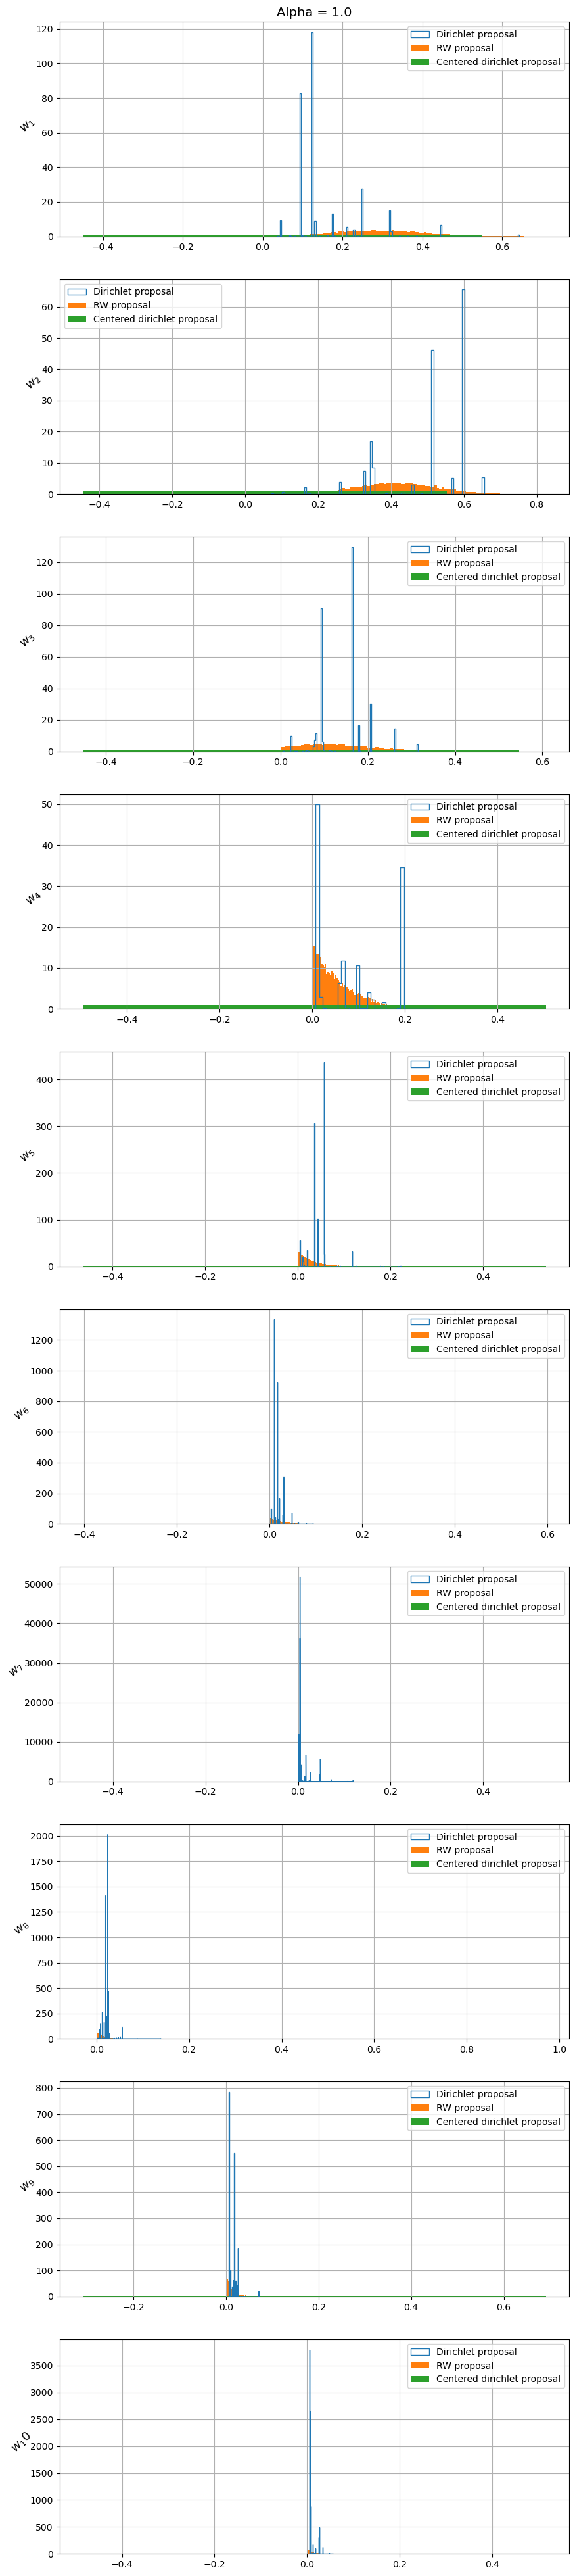

In [8]:
fig, axs = plt.subplots( n_pars, figsize = [10,5*n_pars] )
w = samples
w2 = samples2
w3 = samples5
x = np.arange(0, len(w[0]))
for i in range(n_pars):
    axs[i].hist(np.transpose(w)[i], bins = 'auto', histtype='step', density = True, label = 'Dirichlet proposal')
    axs[i].hist(np.transpose(w2)[i], bins = 'auto', density = True, label = 'RW proposal')
    axs[i].hist(np.transpose(w3)[i], bins = 'auto', density = True, label = 'Centered dirichlet proposal')
    axs[i].set_ylabel(f'$w_{i+1}$', rotation = 45, size = '13')
    axs[i].grid()
    axs[i].legend()
    #axs[i].set_ylim([0,100])
axs[0].set_title(f'Alpha = {alpha[0]}', size = 14)
#plt.savefig('Alpha'+str(alpha[0])+'_second.png')
plt.show()
plt.close()

100%|██████████| 10/10 [00:00<00:00, 20.44it/s]


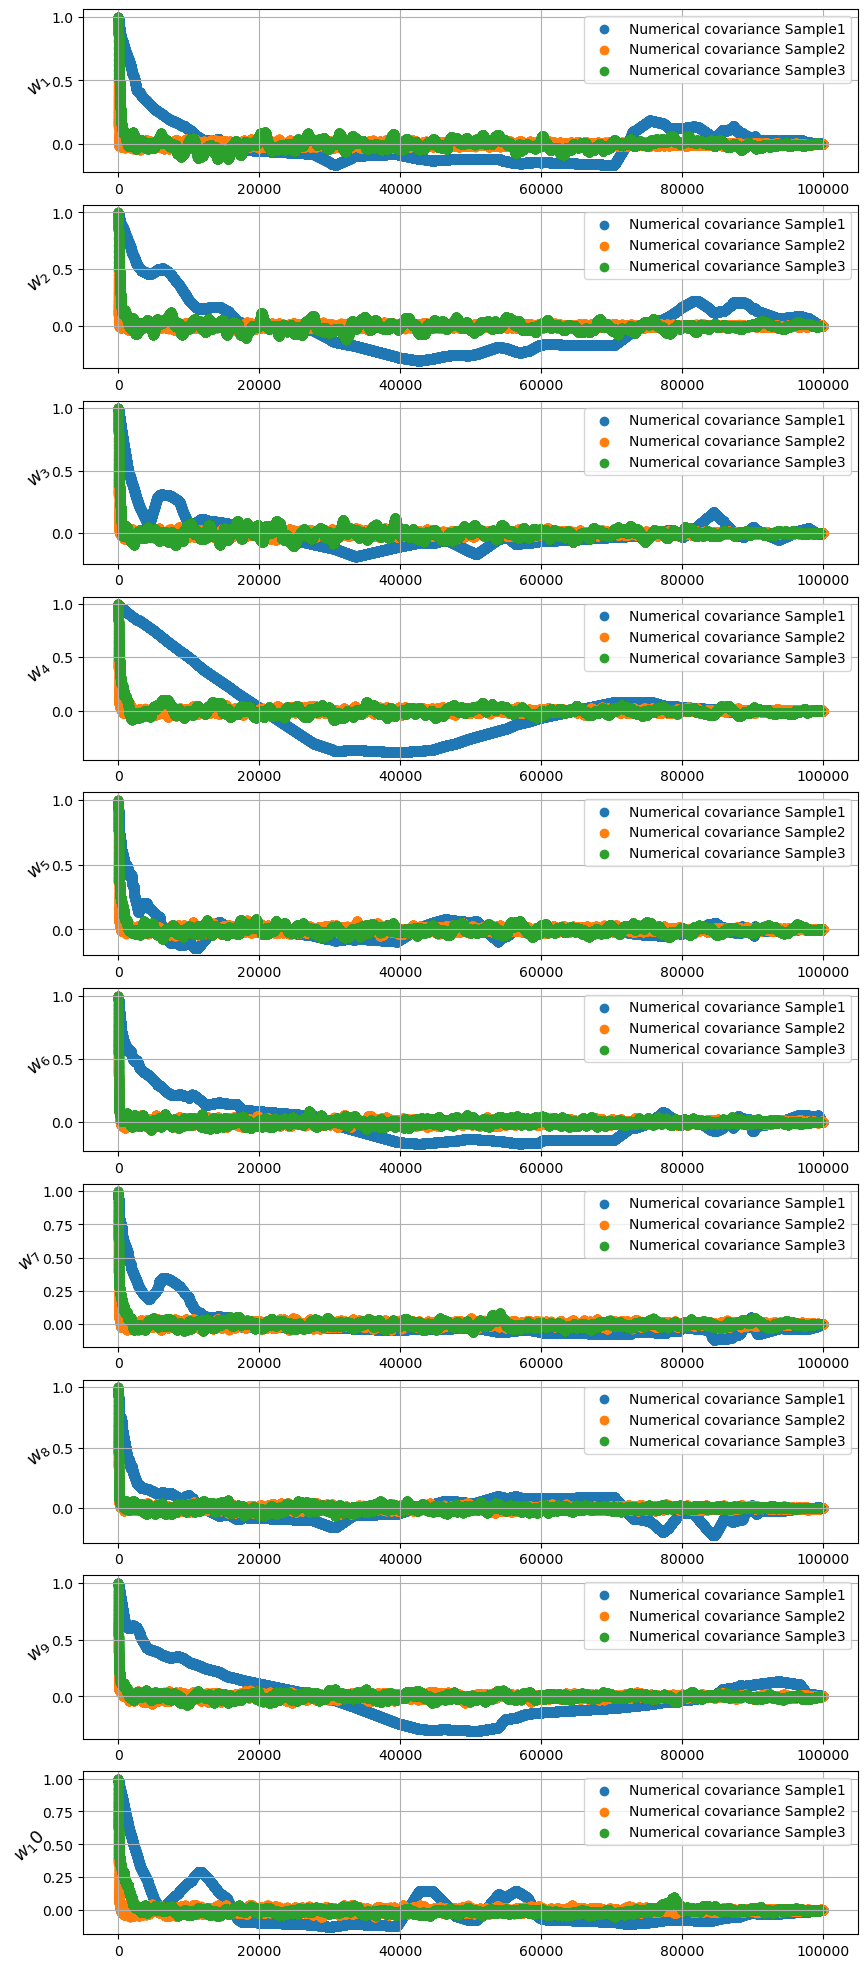

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


In [9]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i
    
def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))
    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n
    # Optionally normalize
    if norm:
        acf /= acf[0]
    return acf

smp = np.transpose(samples)
smp2 = np.transpose(samples2)
smp3 = np.transpose(samples3)
nn = len(samples)
cors = np.zeros((n_pars,nn))
cors2 = np.zeros((n_pars,nn))
cors3 = np.zeros((n_pars,len(samples3)))

fig, axs = plt.subplots( n_pars, figsize = [10,2.5*n_pars] )
x = np.arange(0, nn)
for i in tqdm.tqdm( range(n_pars) ):
    axs[i].set_ylabel(f'$w_{i+1}$', rotation = 45, size = '13')
    cors[i] = autocorr_func_1d(smp[i], norm=True)
    axs[i].scatter(x, cors[i], label = 'Numerical covariance Sample1')
    cors2[i] = autocorr_func_1d(smp2[i], norm=True)
    axs[i].scatter(x, cors2[i], label = 'Numerical covariance Sample2')
    cors3[i] = autocorr_func_1d(smp3[i], norm=True)
    axs[i].scatter(np.arange(0, len(samples3)), cors3[i], label = 'Numerical covariance Sample3')
    axs[i].grid()
    axs[i].legend()
plt.show()
plt.close()
taus = 1 + 2*np.sum(cors, axis = 1)
print(taus)

100%|██████████| 10/10 [00:00<00:00, 60.24it/s]


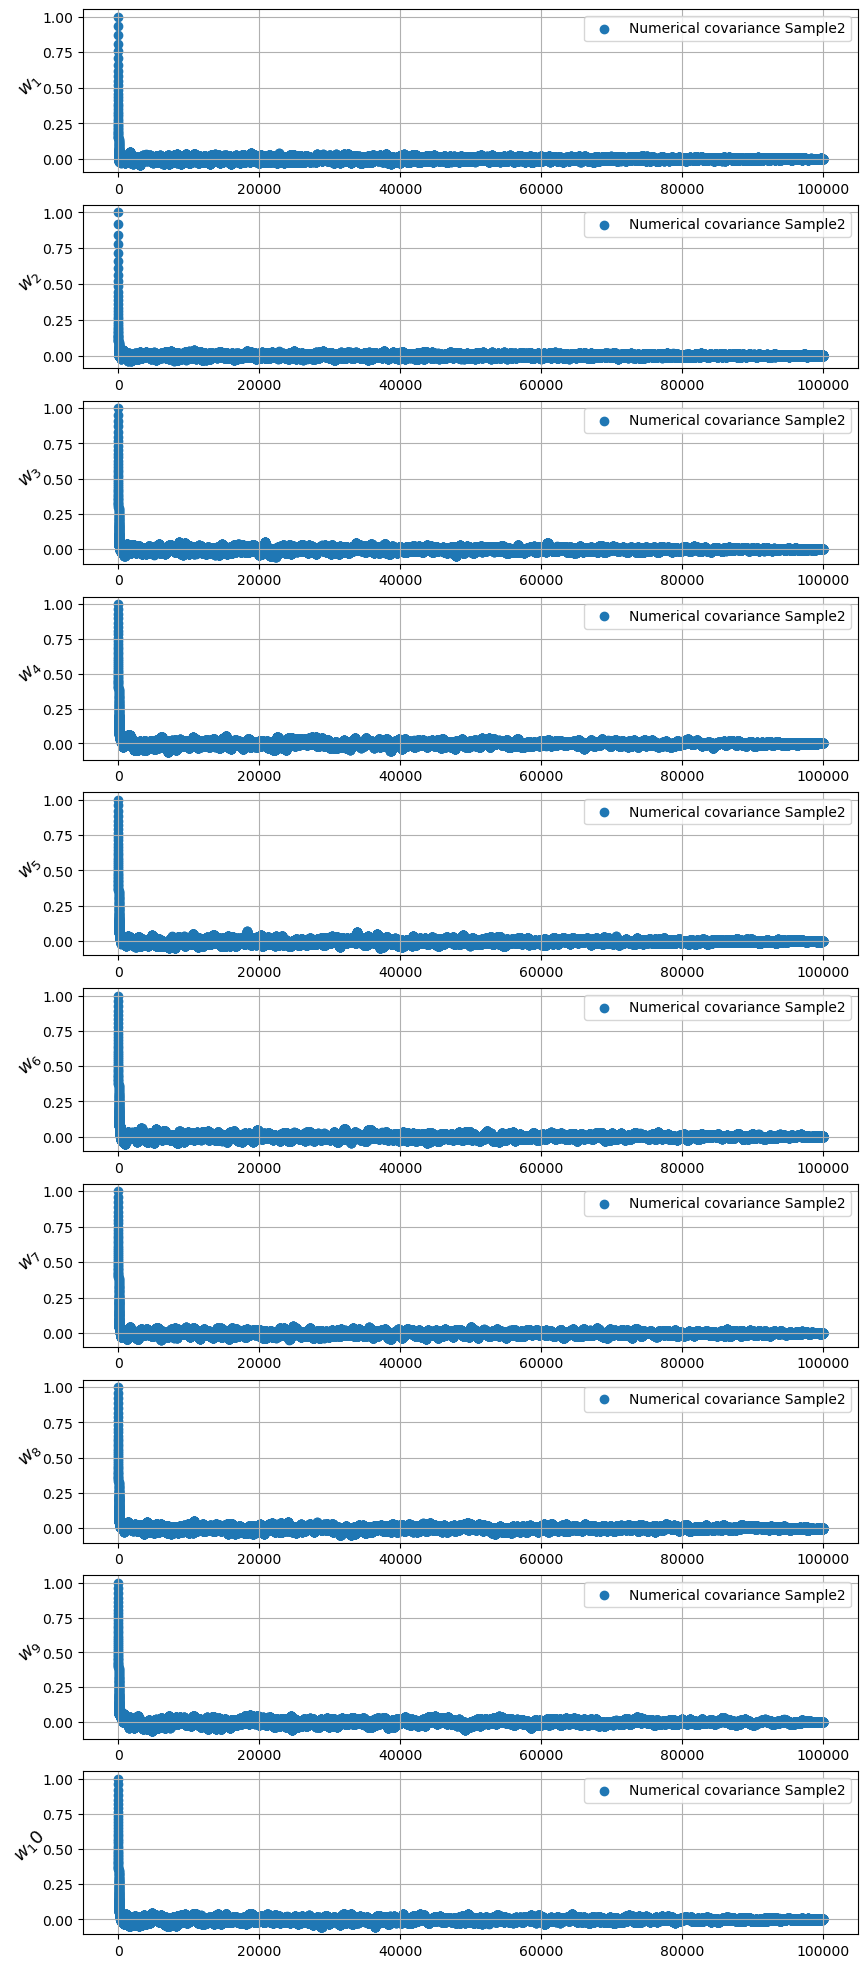

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


In [10]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i
    
def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))
    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n
    # Optionally normalize
    if norm:
        acf /= acf[0]
    return acf

smp = np.transpose(samples2)
nn = len(samples2)
cors = np.zeros((n_pars,nn))

fig, axs = plt.subplots( n_pars, figsize = [10,2.5*n_pars] )
x = np.arange(0, nn)
for i in tqdm.tqdm( range(n_pars) ):
    axs[i].set_ylabel(f'$w_{i+1}$', rotation = 45, size = '13')
    cors[i] = autocorr_func_1d(smp[i], norm=True)
    axs[i].scatter(x, cors[i], label = 'Numerical covariance Sample2')
    axs[i].grid()
    axs[i].legend()
plt.show()
plt.close()
taus = 1 + 2*np.sum(cors, axis = 1)
print(taus)